<a href="https://colab.research.google.com/github/C00ldudeNoonan/basic_marketing_analytics/blob/main/Basic_Marketing_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

Goals of Analysis


* Actionable insights
* Effectiveness metrics
* Efficiency metrics
* Points of Leverage


Analysis Examples

The funnel(Facebook Ads)

Audience-Geographic (Google Analytics)

Creative (Google Analytics)

Date Time (Google Analytics)



In [98]:
import duckdb
import pandas as pd
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
# Use the filterwarnings method to suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)


csv_urls = [
    "https://raw.githubusercontent.com/C00ldudeNoonan/basic_marketing_analytics/main/facebook_ads_data.csv",
    "https://raw.githubusercontent.com/C00ldudeNoonan/basic_marketing_analytics/main/geographic_data.csv",
    "https://raw.githubusercontent.com/C00ldudeNoonan/basic_marketing_analytics/main/google_analytics_data.csv"
]

# Create a DuckDB connection
con = duckdb.connect(database=':memory:')

# Read each CSV into a separate dataframe and create a corresponding DuckDB table
for url in csv_urls:
    df = pd.read_csv(url)
    table_name = url.split("/")[-1].split(".")[0]
    print('Table: ', table_name)
    print(df.columns)
    con.execute(f"CREATE TABLE {table_name} AS SELECT * FROM read_csv_auto('{url}');")

# Verify the tables in DuckDB
tables = con.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables in DuckDB:")
for table in tables:
    print(table[0])


Table:  facebook_ads_data
Index(['campaign', 'ad_name', 'period_start_date', 'period_end_date',
       'impressions', 'frequency', 'link_clicks', 'ctr', 'amount_spent', 'cpc',
       'website_purchases', 'conversion_rate', 'cost_per_conversion'],
      dtype='object')
Table:  geographic_data
Index(['state_fips', 'state', 'state_abbr', 'zipcode', 'county', 'city', 'Lat',
       'Long'],
      dtype='object')
Table:  google_analytics_data
Index(['purchase_amount', 'city', 'state', 'utm_campaign', 'utm_ad',
       'utm_source', 'utm_channel', 'date'],
      dtype='object')
Tables in DuckDB:
facebook_ads_data
geographic_data
google_analytics_data


## Funnel Anaylsis

Facebook Ads



In [19]:
funnel_ads = con.sql("""SELECT
                            ad_name,
                            'impressions' AS metric_name,
                            SUM(CAST(REPLACE(impressions, ',', '') AS float)) AS value
                        FROM
                            facebook_ads_data
                        GROUP BY
                            ad_name

                        UNION ALL

                        SELECT
                            ad_name,
                            'link_clicks' AS metric_name,
                            SUM(CAST(link_clicks AS float)) AS value
                        FROM
                            facebook_ads_data
                        GROUP BY
                            ad_name

                        UNION ALL

                        SELECT
                            ad_name,
                            'purchase' AS metric_name,
                            SUM(CAST(website_purchases AS float)) AS value
                        FROM
                            facebook_ads_data
                        GROUP BY
                            ad_name;
                            """).to_df()
print(funnel_ads)

   ad_name  metric_name    value
0      Two  impressions  57975.0
1    Three  impressions  40281.0
2     Four  impressions  35278.0
3      One  impressions  52690.0
4      Two  link_clicks   5775.0
5    Three  link_clicks   4020.0
6     Four  link_clicks   2093.0
7      One  link_clicks   3242.0
8      Two     purchase    190.0
9    Three     purchase    177.0
10    Four     purchase     37.0
11     One     purchase     52.0


In [ ]:
funnel_ads = con.sql("""SELECT
                            ad_name,
                            'impressions' AS metric_name,
                            SUM(CAST(REPLACE(impressions, ',', '') AS float)) AS value
                        FROM
                            facebook_ads_data
                        GROUP BY
                            ad_name

                        UNION ALL

                        SELECT
                            ad_name,
                            'link_clicks' AS metric_name,
                            SUM(CAST(link_clicks AS float)) AS value
                        FROM
                            facebook_ads_data
                        GROUP BY
                            ad_name

                        UNION ALL

                        SELECT
                            ad_name,
                            'purchase' AS metric_name,
                            SUM(CAST(website_purchases AS float)) AS value
                        FROM
                            facebook_ads_data
                        GROUP BY
                            ad_name;
                            """).to_df()

funnel_pct = con.sql("""SELECT
                            ad_name
                            ,ROUND(SUM(CAST(link_clicks as float))/SUM(CAST(REPLACE(impressions, ',', '') AS float))*100, 2) as click_rate
                            ,ROUND(SUM(CAST(website_purchases as float))/SUM(CAST(link_clicks as float))*100, 2) as conversion_rate
                        FROM
                            facebook_ads_data
                        GROUP BY
                        ad_name
                            """).to_df()


print(funnel_pct)
print(funnel_ads.head(3))



fig = px.funnel(funnel_ads, x='value', y='metric_name', color='ad_name')
fig.show()

In [ ]:
# geographic analysis
# geo cte step to remove duplicate cities


geo_df = con.query(""" WITH Totals as(
                    SELECT
                    SUM(cast(purchase_amount as float)) as total_purchase
                    ,city
                    ,state

                    FROM google_analytics_data
                    GROUP BY
                    city,
                    state
                    ),

                    geo as(
                        SELECT
                        gd.city
                        ,gd.state
                        ,min(CAST(lat as float)) as lat
                        ,min(CAST(long as float)) as long
                        FROM geographic_data gd
                        WHERE lat <> '#N/A' OR long <> '#N/A'
                        GROUP BY
                        gd.city
                        ,gd.state
                    )

                    SELECT
                    totals.total_purchase
                    ,totals.city
                    ,totals.state
                    ,geo.lat
                    ,geo.long
                    from totals
                    LEFT JOIN geo
                      on geo.state = totals.state
                      and geo.city = totals.city
                    """).to_df()


print(geo_df.head())


geo_df['text'] = geo_df['city'] + '<br>Revenue ' + (geo_df['total_purchase']).astype(str)
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
cities = []
scale = 5000

fig = go.Figure()


df_sub = geo_df
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_sub['long'],
    lat = df_sub['lat'],
    text = df_sub['text'],
    marker = dict(
        size = df_sub['total_purchase'],
        color ="green",
        line_color='rgb(40,40,40)',
        line_width=0.5,
        sizemode = 'area'
    )))

fig.update_layout(
        title_text = 'Q4 Puchases - Google Anayltics<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()


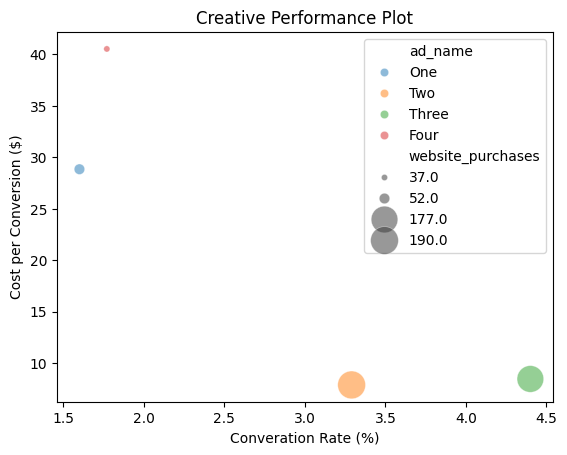

  source     ad   campaign  total_sold  total_spent        roi%
0     fb  three  promotion      6050.0       1500.0  303.333333
2     fb    one    branded       700.0       1500.0  -53.333333
3     fb    two    branded      3870.0       1500.0  158.000000
4     fb   four  promotion       390.0       1500.0  -74.000000
Total Ad ROI:  84.0 %


In [124]:
creative_df = con.query("""
                          SELECT
                          campaign
                          ,ad_name
                          ,SUM(CAST(REPLACE(impressions, ',', '') AS float)) as impressions
                          ,sum(CAST(website_purchases as float)) as website_purchases
                          ,ROUND(SUM(CAST(website_purchases as float))/SUM(CAST(link_clicks as float))*100, 2) as conversion_rate
                          ,ROUND(SUM(CAST(link_clicks as float))/SUM(CAST(REPLACE(impressions, ',', '') AS float))*100, 2) as click_rate
                          ,ROUND(SUM(CAST(amount_spent AS float))/SUM(CAST(website_purchases as float)), 2) as cost_per_conversion
                          FROM facebook_ads_data
                          GROUP BY
                          campaign,
                          ad_name
                        """).to_df()


roi_df = con.query("""With google_analytics as (SELECT
                      utm_source,
                      utm_ad,
                      utm_campaign,
                      sum(purchase_amount) as total_sold
                      FROM google_analytics_data
                      GROUP BY
                      utm_source,
                      utm_ad,
                      utm_campaign),

                      facebook as (
                        SELECT
                          lower(campaign) as campaign
                          ,lower(ad_name) as ad_name
                          ,sum(CAST(amount_spent as float)) as total_spent

                        FROM facebook_ads_data
                        GROUP by
                        campaign,
                        ad_name
                        )

                        Select
                        ga.utm_source as source
                        ,ga.utm_ad as ad
                        ,ga.utm_campaign as campaign
                        ,ga.total_sold
                        ,IFNULL(fb.total_spent, 0) As total_spent

                        FROM google_analytics ga
                        LEFT JOIN facebook fb
                          on ga.utm_ad = fb.ad_name
                          AND ga.utm_campaign = fb.campaign

                      """).to_df()


fig, ax = plt.subplots()
sns.color_palette("flare")
sns.scatterplot(data=creative_df, x="conversion_rate", y="cost_per_conversion", size="website_purchases",hue="ad_name", alpha=0.5, sizes=(20, 400), ax=ax)
ax.set_title("Creative Performance Plot")
ax.set_xlabel('Converation Rate (%)')
ax.set_ylabel('Cost per Conversion ($)')
plt.show()

#
roi_df['roi%'] = ((roi_df['total_sold'] - roi_df['total_spent'])/roi_df['total_spent'])*100
roi_df =  roi_df[roi_df['source']=='fb']
print(roi_df.head())

print("Total Ad ROI: ",str(round((roi_df['total_sold'].sum() - roi_df['total_spent'].sum())/roi_df['total_spent'].sum(), 2)*100) +' %')


   day_of_week  total_amount  units_sold
0            0        2680.0          74
1            1        2500.0          69
2            2        1605.0          46
3            3        2135.0          67
4            4        1910.0          55
5            5        2760.0          82
6            6        2420.0          67


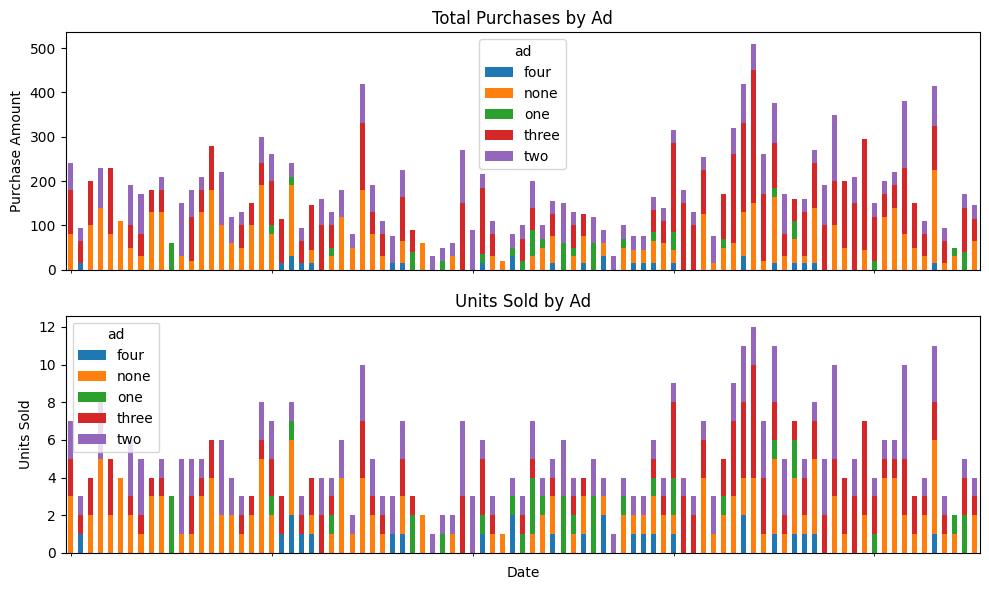

In [138]:
# time series google analytics and day of the week bar chart
time_seriesdf =  con.query("""SELECT
                                    CAST(date as date) as date
                                    ,sum(purchase_amount) as total_amount
                                    ,COUNT(*) as units_sold
                                    ,utm_ad as ad
                                    FROM google_analytics_data
                                    GROUP BY
                                    CAST(date as date),
                                    ad""").to_df()

day_of_week_df = con.query("""
                            SELECT
                            dayofweek(CAST(date as date)) as day_of_week
                            ,sum(purchase_amount) as total_amount
                            ,COUNT(*) as units_sold
                            FROM google_analytics_data
                            GROUP BY
                            dayofweek(CAST(date as date))
                            """).to_df()
print(day_of_week_df.head(10))
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
df_pivot = time_seriesdf.pivot(index='date', columns='ad', values='total_amount')
df2_pivot = time_seriesdf.pivot(index='date', columns='ad', values='units_sold')

# Stacked area plot for total purchases by ad
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), ax=axes[0])

axes[0].set_title('Total Purchases by Ad')
axes[0].set_ylabel('Purchase Amount')

# Stacked area plot for total purchases amount
df2_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), ax=axes[1])

axes[1].set_title('Units Sold by Ad')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Units Sold')
axes[1]
plt.xticks([])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()